The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Modelos Sequenciais
:label:`sec_sequence`


Imagine que você está assistindo a filmes na Netflix. Como um bom usuário do Netflix, você decide avaliar cada um dos filmes religiosamente. Afinal, um bom filme é um bom filme, e você quer assistir mais deles, certo? Acontece que as coisas não são tão simples. As opiniões das pessoas sobre os filmes podem mudar significativamente com o tempo. Na verdade, os psicólogos até têm nomes para alguns dos efeitos:

* Há *ancoragem*, com base na opinião de outra pessoa. Por exemplo, após a premiação do Oscar, as avaliações do filme correspondente aumentam, embora ainda seja o mesmo filme. Este efeito persiste por alguns meses até que o prêmio seja esquecido. Foi demonstrado que o efeito eleva a classificação em mais de meio ponto
:cite:`Wu.Ahmed.Beutel.ea.2017`.
* Existe a *adaptação hedônica*, onde os humanos se adaptam rapidamente para aceitar uma situação melhorada ou piorada como o novo normal. Por exemplo, depois de assistir a muitos filmes bons, as expectativas de que o próximo filme seja igualmente bom ou melhor são altas. Consequentemente, mesmo um filme comum pode ser considerado ruim depois que muitos filmes incríveis são assistidos.
* Existe *sazonalidade*. Muito poucos espectadores gostam de assistir a um filme do Papai Noel em agosto.
* Em alguns casos, os filmes se tornam impopulares devido ao mau comportamento de diretores ou atores na produção.
* Alguns filmes se tornam filmes de culto, porque eram quase comicamente ruins. *Plan 9 from Outer Space* e *Troll 2* alcançaram um alto grau de notoriedade por este motivo.

Resumindo, as avaliações dos filmes são tudo menos estacionárias. Assim, usando a dinâmica temporal
levou a recomendações de filmes mais precisas :cite:`Koren.2009`.
É claro que os dados da sequência não se referem apenas às classificações dos filmes. O seguinte fornece mais ilustrações.

* Muitos usuários têm um comportamento altamente específico quando se trata do momento em que abrem aplicativos. Por exemplo, os aplicativos de mídia social são muito mais populares entre os alunos depois da escola. Os aplicativos de negociação do mercado de ações são mais comumente usados ​​quando os mercados estão abertos.
* É muito mais difícil prever os preços das ações de amanhã do que preencher as lacunas de um preço das ações que perdemos ontem, embora ambos sejam apenas uma questão de estimar um número. Afinal, a previsão é muito mais difícil do que a retrospectiva. Em estatística, a primeira (previsão além das observações conhecidas) é chamada de *extrapolação*, enquanto a última (estimativa entre as observações existentes) é chamada de *interpolação*.
* Música, fala, texto e vídeos são todos sequenciais por natureza. Se fôssemos permutá-los, eles fariam pouco sentido. O título *cachorro morde homem* é muito menos surpreendente do que *homem morde cachorro*, embora as palavras sejam idênticas.
* Terremotos estão fortemente correlacionados, ou seja, após um grande terremoto, é muito provável que ocorram vários tremores menores, muito mais do que sem o forte terremoto. Na verdade, os terremotos são correlacionados espaço-temporalmente, ou seja, os tremores secundários ocorrem normalmente em um curto espaço de tempo e nas proximidades.
* Os humanos interagem uns com os outros em uma natureza sequencial, como pode ser visto nas lutas do Twitter, padrões de dança e debates.

## Ferramentas Estatísticas

Precisamos de ferramentas estatísticas e novas arquiteturas de rede neural profunda para lidar com dados de sequência. Para manter as coisas simples, usamos o preço das ações (índice FTSE 100) ilustrado em :numref:`fig_ftse100 como exemplo.

![Índice FTSE 100 ao longo de cerca de 30 anos.](../img/ftse100.png)
:width:`400px`
:label:`fig_ftse100`


Vamos denotar os preços por $x_t$, ou seja, no *passo de tempo*$t \in \mathbb{Z}^+$ observamos o preço $x_t$.
Observe que para sequências neste texto,
$t$ normalmente será discreto e variará em números inteiros ou em seu subconjunto.
Suponha que
um trader que deseja ter um bom desempenho no mercado de ações no dia $t$ prevê $x_t$ via

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

### Modelos Autorregressivos


Para conseguir isso, nosso trader pode usar um modelo de regressão como o que treinamosem :numref:`sec_linear_concise`.
Existe apenas um grande problema: o número de entradas, $x_{t-1}, \ldots, x_1$ varia, dependendo de $t$.
Ou seja, o número aumenta com a quantidade de dados que encontramos e precisaremos de uma aproximação para tornar isso computacionalmente tratável.
Muito do que se segue neste capítulo girará em torno de como estimar $P(x_t \mid x_{t-1}, \ldots, x_1)$ de forma eficiente. Em poucas palavras, ele se resume a duas estratégias como segue.

Primeiro, assuma que a sequência potencialmente bastante longa $ $x_{t-1}, \ldots, x_1$ não é realmente necessária.
Neste caso, podemos nos contentar com algum intervalo de tempo de comprimento $\tau$ e usar apenas observações $x_{t-1}, \ldots, x_{t-\tau}$. O benefício imediato é que agora o número de argumentos é sempre o mesmo, pelo menos para $t > \tau$. Isso nos permite treinar uma rede profunda, conforme indicado acima. Esses modelos serão chamados de *modelos autorregressivos*, pois eles literalmente realizam regressão em si mesmos.

A segunda estratégia, mostrada em :numref:`fig_sequence-model`,  é manter algum resumo $h_t$ das observações anteriores, e ao mesmo tempo atualizar $h_t$ além da previsão $\hat{x}_t$.
Isso leva a modelos que estimam $x_t$ com $\hat{x}_t = P(x_t \mid h_{t})$ e, além disso, atualizações da forma $h_t = g(h_{t-1}, x_{t-1})$.  Como $h_t$ nunca é observado, esses modelos também são chamados de *modelos autorregressivos latentes*.

![Um modelo autorregressivo latente.](../img/sequence-model.svg)
:label:`fig_sequence-model`

Ambos os casos levantam a questão óbvia de como gerar dados de treinamento. Normalmente, usa-se observações históricas para prever a próxima observação, dadas as até agora. Obviamente, não esperamos que o tempo pare. No entanto, uma suposição comum é que, embora os valores específicos de $x_t$ possam mudar, pelo menos a dinâmica da própria sequência não mudará. Isso é razoável, uma vez que novas dinâmicas são apenas isso, novas e, portanto, não previsíveis usando os dados que temos até agora. Os estatísticos chamam a dinâmica que não muda de *estacionária*.
Independentemente do que fizermos, obteremos uma estimativa de toda a sequência por meio de

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

Observe que as considerações acima ainda valem se lidarmos com objetos discretos, como palavras, em vez de números contínuos. A única diferença é que, em tal situação, precisamos usar um classificador em vez de um modelo de regressão para estimar $P(x_t \mid  x_{t-1}, \ldots, x_1)$.

### Modelos de Markov

Lembre-se da aproximação de que em um modelo autoregressivo usamos apenas $x_{t-1}, \ldots, x_{t-\tau}$ em vez de $x_{t-1}, \ldots, x_1$ para estimar $x_t$ . Sempre que essa aproximação for precisa, dizemos que a sequência satisfaz uma *condição de Markov*. Em particular, se $\tau = 1$,  temos um *modelo de Markov de primeira ordem* e $P(x)$ é dado por

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ onde } P(x_1 \mid x_0) = P(x_1).$$

Esses modelos são particularmente bons sempre que $x_t$ assume apenas um valor discreto, uma vez que, neste caso, a programação dinâmica pode ser usada para calcular valores exatamente ao longo da cadeia. Por exemplo, podemos calcular $P(x_{t+1} \mid x_{t-1})$ de forma eficiente:

$$\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

usando o fato de que só precisamos levar em consideração um histórico muito curto de observações anteriores: $P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$.
Entraremos em detalhes da programação dinâmica está além do escopo desta seção. Algoritmos de aprendizagem de controle e reforço usam essas ferramentas extensivamente.

### Causalidade

Em princípio, não há nada de errado em desdobrar $P(x_1, \ldots, x_T)$ na ordem inversa. Afinal, por condicionamento, podemos sempre escrevê-la via

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

Na verdade, se tivermos um modelo de Markov, também podemos obter uma distribuição de probabilidade condicional reversa. Em muitos casos, no entanto, existe uma direção natural para os dados, a saber, avançar no tempo. É claro que eventos futuros não podem influenciar o passado. Portanto, se mudarmos $x_t$, podemos influenciar o que acontece com $x_{t+1}$ daqui para frente, mas não o contrário. Ou seja, se mudarmos $x_t$, a distribuição sobre os eventos anteriores não mudará. Consequentemente, deveria ser mais fácil explicar $P(x_{t+1} \mid x_t)$ em vez de $P(x_t \mid x_{t+1})$. Por exemplo, foi mostrado que em alguns casos podemos encontrar $x_{t+1} = f(x_t) + \epsilon$ para algum ruído aditivo $\epsilon$, enquanto o inverso não é verdadeiro :cite:`Hoyer.Janzing.Mooij.ea.2009`. Esta é uma ótima notícia, pois normalmente é a direção para a frente que estamos interessados ​​em estimar.
O livro de Peters et al.
explicou mais sobre este tópico :cite:`Peters.Janzing.Scholkopf.2017`.
Estamos apenas arranhando a superfície disso.


## Trainamento

Depois de revisar tantas ferramentas estatísticas,
vamos tentar isso na prática.
Começamos gerando alguns dados.
Para manter as coisas simples, geramos nossos dados de sequência usando uma função seno com algum ruído aditivo para etapas de tempo $1, 2, \ldots, 1000$.


In [1]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

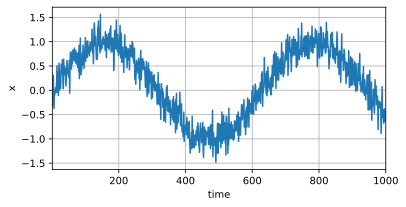

In [2]:
T = 1000  # Generate a total of 1000 points
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

Em seguida, precisamos transformar essa sequência em recursos e rótulos nos quais nosso modelo pode treinar.
Com base na dimensão de incorporação $\tau$, mapeamos os dados em pares $y_t = x_t$ e $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.
O leitor astuto deve ter notado que isso nos dá $\tau$ menos exemplos de dados, uma vez que não temos histórico suficiente para os primeiros $\tau$ deles.
Uma solução simples, em particular se a sequência for longa,
é descartar esses poucos termos.
Como alternativa, podemos preencher a sequência com zeros.
Aqui, usamos apenas os primeiros 600 pares de rótulos de recursos para treinamento.


In [3]:
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i: T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

In [4]:
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

Aqui, mantemos a arquitetura bastante simples:
apenas um MLP com duas camadas totalmente conectadas, ativação ReLU e perda quadrática.


In [5]:
# Vanilla MLP architecture
def get_net():
    net = tf.keras.Sequential([tf.keras.layers.Dense(10, activation='relu'),
                              tf.keras.layers.Dense(1)])
    return net

# Least mean squares loss
# Note: L2 Loss = 1/2 * MSE Loss. TensorFlow has MSE Loss that is slightly
# different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
# value to get L2Loss in TF
loss = tf.keras.losses.MeanSquaredError()

Agora estamos prontos para treinar o modelo. O código abaixo é essencialmente idêntico ao loop de treinamento nas seções anteriores,
como :numref:`sec_linear_concise`.
Portanto, não iremos nos aprofundar em muitos detalhes.


In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out) / 2
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.066722


epoch 2, loss: 0.052959


epoch 3, loss: 0.052756


epoch 4, loss: 0.052145


epoch 5, loss: 0.052316


## Predição

Como a perda de treinamento é pequena, esperamos que nosso modelo funcione bem. Vamos ver o que isso significa na prática. A primeira coisa a verificar é o quão bem o modelo é capaz de prever o que acontece na próxima etapa,
ou seja, a *previsão um passo à frente*.


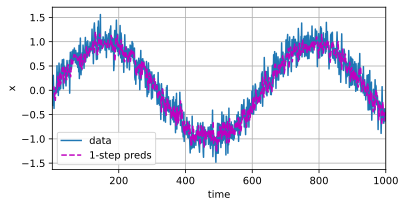

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.numpy(), onestep_preds.numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

As previsões de um passo à frente parecem boas, exatamente como esperávamos.
Mesmo além de 604 (`n_train + tau`) observações, as previsões ainda parecem confiáveis.
No entanto, há apenas um pequeno problema para isso:
se observarmos os dados de sequência apenas até a etapa de tempo 604, não podemos esperar receber as entradas para todas as previsões futuras de um passo à frente.
Em vez disso, precisamos trabalhar nosso caminho adiante, um passo de cada vez:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Geralmente, para uma sequência observada até $x_t$, sua saída prevista $\hat{x}_{t+k}$ no passo de tempo $t+k$ é chamada de $k$ *- previsão passo à frente*. Como observamos até $x_{604}$, sua previsão de $k$-step-forward é $\hat{x}_{604+k}$.
Em outras palavras, teremos que usar nossas próprias previsões para fazer previsões em várias etapas.
Vamos ver como isso vai bem.


In [8]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i - tau: i], (1, -1))), ()))

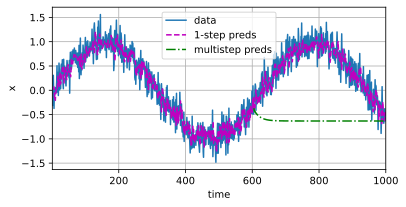

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.numpy(), onestep_preds.numpy(),
          multistep_preds[n_train + tau:].numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

Como mostra o exemplo acima, este é um fracasso espetacular. As previsões decaem para uma constante muito rapidamente após algumas etapas de previsão.
Por que o algoritmo funcionou tão mal?
Em última análise, isso se deve ao fato de que os erros se acumulam.
Digamos que após o passo 1 tenhamos algum erro $\epsilon_1 = \bar\epsilon$.
Agora a *entrada* para a etapa 2 é perturbada por $\epsilon_1$, portanto, sofremos algum erro na ordem de $\epsilon_2 = \bar\epsilon + c \epsilon_1$ para alguma constante $c$, e assim por diante. O erro pode divergir rapidamente das observações verdadeiras. Este é um fenômeno comum. Por exemplo, as previsões do tempo para as próximas 24 horas tendem a ser bastante precisas, mas, além disso, a precisão diminui rapidamente. Discutiremos métodos para melhorar isso ao longo deste capítulo e além.

Vamos dar uma olhada mais de perto nas dificuldades nas previsões de $k$-step-ahead
calculando previsões em toda a sequência para $k = 1, 4, 16, 64$.


In [10]:
max_steps = 64

In [11]:
features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i].assign(x[i: i + T - tau - max_steps + 1].numpy())

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net((features[:, i - tau: i])), -1))

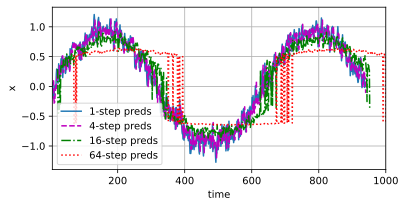

In [12]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes as we try to predict further into the future.
While the 4-step-ahead predictions still look good, anything beyond that is almost useless.


## Resumo

* Existe uma grande diferença de dificuldade entre interpolação e extrapolação. Consequentemente, se você tiver uma sequência, sempre respeite a ordem temporal dos dados ao treinar, ou seja, nunca treine com dados futuros.
* Os modelos de sequência requerem ferramentas estatísticas especializadas para estimativa. Duas escolhas populares são os modelos autorregressivos e os modelos autorregressivos de variáveis latentes.
* Para modelos causais (por exemplo, o tempo indo para frente), estimar a direção para frente é normalmente muito mais fácil do que a direção reversa.
* Para uma sequência observada até o passo de tempo $t$, sua saída prevista no passo de tempo $t+k$ is the $k$*-previsão de avanço *. Como prevemos mais no tempo aumentando $k$, os erros se acumulam e a qualidade da previsão se degrada, muitas vezes de forma dramática.

## Exercícios

1. Melhore o modelo no experimento desta seção.
     1. Incorpora mais do que as últimas 4 observações? De quantas você realmente precisa?
     1. Quantas observações anteriores você precisaria se não houvesse ruído? Dica: você pode escrever $\sin$ e $\cos$ como uma equação diferencial.
     1. Você pode incorporar observações mais antigas enquanto mantém constante o número total de recursos? Isso melhora a precisão? Por quê?
     1. Altere a arquitetura da rede neural e avalie o desempenho.
1. Um investidor deseja encontrar um bom título para comprar. Ele olha para os retornos anteriores para decidir qual deles provavelmente terá um bom desempenho. O que poderia dar errado com essa estratégia?
1. A causalidade também se aplica ao texto? Até que ponto?
1. Dê um exemplo de quando um modelo autoregressivo latente pode ser necessário para capturar a dinâmica dos dados.


[Discussions](https://discuss.d2l.ai/t/1048)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMzU2MDc3MTU2LDIwNTQ3MDU1OTEsMTUxNz
Y5NDM5NSwtNDYzMjk3MjEwLC0xMDgyMTEzMjE3XX0=
-->
